In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib import cm
import seaborn as sns
import glob
import pickle
from collections import defaultdict
from Bio.Seq import Seq
import ete3

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_57355/3335900615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load GC trees

In [2]:
results = "../nextflow/results"

In [3]:
metadata_PR1 = pd.read_csv("../metadata.PR1.csv")[["imm_duration", "strain", "mouse", "gc", "node", "cell_type"]]
metadata_PR1["pr"] = "1"
metadata_PR1["gc"] = metadata_PR1["gc"].astype(str)
metadata_PR1.rename({"imm_duration": "time"}, axis=1, inplace=True)
metadata_PR2 = pd.read_csv("../metadata.PR2.csv")[["mouse", "gc", "node", "cell_type"]]
metadata_PR2["pr"] = "2"
metadata_PR2["time"] = "d15"
metadata_PR2["strain"] = "wt"

metadata = pd.concat([metadata_PR1, metadata_PR2], ignore_index=True)
metadata.index = "PR" + metadata["pr"] + "_mouse" + metadata["mouse"].astype(str) + "_GC" + metadata["gc"]
metadata

time strain  mouse   gc node cell_type pr
PR1_mouse1_GC1     d20     wt      1    1   RP        GC  1
PR1_mouse1_GC2     d20     wt      1    2   RP        GC  1
PR1_mouse1_GC3     d20     wt      1    3   RP        GC  1
PR1_mouse1_GC4     d20     wt      1    4   LP        GC  1
PR1_mouse1_GC5     d20     wt      1    5   LP        GC  1
...                ...    ...    ...  ...  ...       ... ..
PR2_mouse12_GC12B  d15     wt     12  12B   LP        GC  2
PR2_mouse12_GC12D  d15     wt     12  12D   LI        GC  2
PR2_mouse12_GC12C  d15     wt     12  12C   RI        GC  2
PR2_mouse10_GC10A  d15     wt     10  10A   RP        GC  2
PR2_mouse9_GC9C    d15     wt      9   9C   RI        GC  2

[127 rows x 7 columns]

In [4]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[0].split(".")[0][2:]), int(PR_str[1]), PR_str[3]

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("PR", "mouse", "GC"), gc_key(file)))
    if (metadata.strain[key] == "wt") and (metadata.time[key] in ("d15", "d20")):
        print(key)
        assert key not in trees, key
        trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

PR1_mouse1_GC1
PR1_mouse1_GC11
PR1_mouse1_GC12
PR1_mouse1_GC13
PR1_mouse1_GC14
PR1_mouse1_GC15
PR1_mouse1_GC16
PR1_mouse1_GC17
PR1_mouse1_GC18
PR1_mouse1_GC19
PR1_mouse1_GC2
PR1_mouse1_GC20
PR1_mouse1_GC3
PR1_mouse1_GC4
PR1_mouse1_GC5
PR1_mouse1_GC6
PR1_mouse1_GC7
PR1_mouse2_GC21
PR1_mouse2_GC22
PR1_mouse2_GC23
PR1_mouse2_GC24
PR1_mouse2_GC25
PR1_mouse2_GC26
PR1_mouse2_GC28
PR1_mouse2_GC29
PR1_mouse2_GC30
PR1_mouse2_GC31
PR1_mouse2_GC32
PR1_mouse2_GC34
PR1_mouse2_GC38
PR1_mouse2_GC39
PR1_mouse2_GC40
PR1_mouse3_GC41
PR1_mouse3_GC42
PR1_mouse3_GC43
PR1_mouse3_GC44
PR1_mouse3_GC45
PR1_mouse3_GC46
PR1_mouse3_GC55
PR1_mouse3_GC56
PR1_mouse3_GC57
PR1_mouse3_GC58
PR1_mouse3_GC59
PR1_mouse3_GC64
PR1_mouse3_GC65
PR1_mouse3_GC66
PR1_mouse3_GC72
PR1_mouse4_GC47
PR1_mouse4_GC48
PR1_mouse4_GC50
PR1_mouse4_GC63
PR1_mouse4_GC67
PR1_mouse4_GC68
PR1_mouse4_GC69
PR1_mouse4_GC70
PR1_mouse4_GC71
PR1_mouse4_GC73
PR1_mouse5_GC78
PR1_mouse5_GC79
PR1_mouse5_GC80
PR1_mouse5_GC81
PR1_mouse5_GC82
PR1_mouse5_GC83

In [5]:
# def gc_key(file):
#     PR_str = file.split("/")[-2].split("-")
#     return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

# files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

# trees = {}
# for file in files:
#     key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
#     if not any(key.split("_")[0] == f"mouse{i}" for i in range(1, 7)):
#         print(f"skipping {key}")
#         continue
#     assert key not in trees, key
#     trees[key] = pickle.load(open(file, "rb"))

    
# #     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
# #          for file in files}

# print(f"loaded {len(trees)} GC trees")

## Mutability model

In [6]:
# mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
# substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

# naive = next(iter(trees.values())).tree.sequence
# igh_frame = 1
# igk_frame = 1
# igk_idx = 336

# def mutate_uniform(sequence):
#     i = np.random.choice(len(sequence))
#     base = sequence[i]
#     alt_base = np.random.choice(list("ACGT".replace(base, "")))
#     sequence = list(sequence)
#     sequence[i] = alt_base
#     return "".join(sequence)

# def mutate_S5F(sequence):
#     sequence_H = "NN" + sequence[:igk_idx] + "NN"
#     sequence_K = "NN" + sequence[igk_idx:] + "NN"
#     # mutabilities of each nucleotide
#     contexts = [sequence_H[(i - 2) : (i + 3)]
#                     for i in range(2, len(sequence_H) - 2)
#                    ] + [sequence_K[(i - 2) : (i + 3)]
#                         for i in range(2, len(sequence_K) - 2)
#                        ]
#     mutabilities = np.array([mutability[context] for context in contexts])
#     i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
#     sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
#     return sequence

# def aa(seq, frame):
#     return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

# def mutations(naive_aa, aa, pos_map, chain_annotation):
#     return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
#             for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
#             if aa1 != aa2]

# naive_igh_aa = aa(naive[:igk_idx], igh_frame)
# naive_igk_aa = aa(naive[igk_idx:], igk_frame)

## DMS data

In [7]:
# dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/improved-Kd-fitting/tite-seq-modeling/output/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

target wildtype  position  position_IMGT chain annotation mutant  \
mutation                                                                        
E1(H)A    CGG_naive        E         1              1     H      FWRH1      A   
E1(H)C    CGG_naive        E         1              1     H      FWRH1      C   
E1(H)D    CGG_naive        E         1              1     H      FWRH1      D   
E1(H)E    CGG_naive        E         1              1     H      FWRH1      E   
E1(H)F    CGG_naive        E         1              1     H      FWRH1      F   
...             ...      ...       ...            ...   ...        ...    ...   
R128(L)S  CGG_naive        R       235            128     L      FWRL4      S   
R128(L)T  CGG_naive        R       235            128     L      FWRL4      T   
R128(L)V  CGG_naive        R       235            128     L      FWRL4      V   
R128(L)W  CGG_naive        R       235            128     L      FWRL4      W   
R128(L)Y  CGG_naive        R       235            128     L      FWRL4      Y   

         codon single_nt  bind_CGG_old  ...  n_bc_expr  n_libs_expr      psr  \
mutation                                ...                                    
E1(H)A     GAG      True      10.48829  ...       19.0          2.0  6.78608   
E1(H)C     GAG     False      10.44477  ...       20.0          2.0  7.44234   
E1(H)D     GAG      True      10.42771  ...       16.0          2.0  6.95940   
E1(H)E     GAG      True      10.45719  ...    21170.0          2.0  6.86060   
E1(H)F     GAG     False      10.51899  ...       24.0          2.0  6.91372   
...        ...       ...           ...  ...        ...          ...      ...   
R128(L)S   CGT      True      10.44756  ...       39.0          2.0  6.93925   
R128(L)T   CGT     False      10.43023  ...       36.0          2.0  6.88956   
R128(L)V   CGT     False      10.38231  ...       27.0          2.0  6.78160   
R128(L)W   CGT     False      10.48219  ...       33.0          2.0  6.91474   
R128(L)Y   CGT     False      10.47297  ...       34.0          2.0  6.96378   

          delta_psr  n_bc_psr  n_libs_psr  bind_CGG  delta_bind_CGG     WT  \
mutation                                                                     
E1(H)A     -0.07452      17.0         2.0  8.743409        0.118716  False   
E1(H)C      0.58174      17.0         2.0  8.608721       -0.015972  False   
E1(H)D      0.09880      13.0         2.0  8.636242        0.011550  False   
E1(H)E      0.00000   18910.0         2.0       NaN             NaN   True   
E1(H)F      0.05313      21.0         2.0  8.758316        0.133624  False   
...             ...       ...         ...       ...             ...    ...   
R128(L)S    0.07866      33.0         2.0  8.634747        0.010054  False   
R128(L)T    0.02896      34.0         2.0  8.644639        0.019946  False   
R128(L)V   -0.07899      24.0         2.0  8.589500       -0.035193  False   
R128(L)W    0.05415      29.0         2.0  8.668018        0.043326  False   
R128(L)Y    0.10318      32.0         2.0  8.631170        0.006477  False   

           site  
mutation         
E1(H)A    H-001  
E1(H)C    H-001  
E1(H)D    H-001  
E1(H)E    H-001  
E1(H)F    H-001  
...         ...  
R128(L)S  L-128  
R128(L)T  L-128  
R128(L)V  L-128  
R128(L)W  L-128  
R128(L)Y  L-128  

[4400 rows x 28 columns]

In [8]:
# pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
# pos_df

In [9]:
# igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
# igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Simulate expression-matched trees

This cell takes a while (~1 hour)

In [10]:
# sim_trees = defaultdict(list)
# expression_threshold = 0.2
# n_replicates = 2
# for gc, tree in trees.items():
#     replicate = 1
#     dead = False
#     while replicate <= n_replicates:
#         print(f"GC {gc} replicate {replicate}", end="   \r")
#         new_tree = tree.tree.copy()
#         for node, node_new in zip(tree.tree.traverse(strategy="preorder"), new_tree.traverse(strategy="preorder")):
#             assert node.name == node_new.name
#             if not node.is_root():
#                 success = False
#                 closest = np.inf
#                 for tries in range(100):
#                     node_new.sequence = node_new.up.sequence
#                     for _ in range(int(node.dist)):
#                         node_new.sequence = mutate_S5F(node_new.sequence)
#                         igh_aa = aa(node_new.sequence[:igk_idx], igh_frame)
#                         igk_aa = aa(node_new.sequence[igk_idx:], igk_frame)
#                         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
#                         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
#                         all_mutations = igh_mutations + igk_mutations
#                         if any("*" in x for x in all_mutations):
#                             node_new.delta_bind_CGG_FVS_additive = None
#                             node_new.delta_expr_FVS_additive = None
#                         else:
#                             node_new.delta_bind_CGG_FVS_additive = dms_df.delta_bind_CGG[all_mutations].sum()
#                             node_new.delta_expr_FVS_additive = dms_df.delta_expr[all_mutations].sum()
#                     # note: selecting on additive expression estimate
#                     if node_new.delta_expr_FVS_additive is None:
#                         continue
#                     delta = np.abs(node_new.delta_expr_FVS_additive - node.delta_expr_FVS_additive)
#                     if delta < closest:
#                         closest = delta
#                         closest_seq = node_new.sequence
#                         delta_bind_CGG = node_new.delta_bind_CGG_FVS_additive
#                         closest_delta_expr = node_new.delta_expr_FVS_additive
#                     if delta < expression_threshold:
#                         success = True
#                         break
#                 if not success:
#                     node_new.sequence = closest_seq
#                     node_new.delta_bind_CGG_FVS_additive = delta_bind_CGG
#                     node_new.delta_expr_FVS_additive = closest_delta_expr

#         sim_trees[gc].append(new_tree)
#         replicate += 1

In [13]:
# sim_df = pd.DataFrame()
# expression_thresh = -1
# replicate = 1
# while replicate < 1000:
#     print(f"replicate {replicate + 1}", end="   \r")
#     sequence = naive
#     n_mutations = 0
#     rows = []
#     while n_mutations <= 20:
#         if n_mutations:
#             new_sequence = mutate_S5F(sequence)
#         else:
#             new_sequence = sequence
#         igh_aa = aa(new_sequence[:igk_idx], igh_frame)
#         igk_aa = aa(new_sequence[igk_idx:], igk_frame)
#         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
#         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")
#         all_mutations = igh_mutations + igk_mutations
#         has_stop = any("*" in mutation for mutation in all_mutations)
#         affinity = np.nan if has_stop else dms_df.delta_bind_CGG[all_mutations].sum()
#         expression = np.nan if has_stop else dms_df.delta_expr[all_mutations].sum()
#         polyspecificity = np.nan if has_stop else dms_df.delta_psr[all_mutations].sum()
#         if expression < expression_thresh:
#             continue
#         new_row = [affinity,
#                    expression,
#                    polyspecificity,
#                    n_mutations,
#                    replicate,
#                   ]
#         rows.append(new_row)
#         sequence = new_sequence
#         n_mutations += 1
#     rep_df = pd.DataFrame(rows, columns=(r"$\Delta$ affinity", r"$\Delta$ expression", r"$\Delta$ polyspecificity", "divergence", "replicate"))
#     sim_df = pd.concat((sim_df, rep_df), ignore_index=True, verify_integrity=True)
#     replicate += 1
# sim_df

In [14]:
output_dir = "output/phenotype-trajectories"

In [15]:
# plt.figure(figsize=(3, 9))
# plt.subplot(311)
# sns.lineplot(data=sim_df, x="divergence", y=r"$\Delta$ affinity",
#              errorbar='sd',
#              # units="replicate", estimator=None, lw=1, alpha=0.5,
#             )
# plt.subplot(312)
# sns.lineplot(data=sim_df, x="divergence", y=r"$\Delta$ expression",
#              errorbar='sd',
#              # units="replicate", estimator=None, lw=1, alpha=0.5,
#             )
# plt.subplot(313)
# sns.lineplot(data=sim_df, x="divergence", y=r"$\Delta$ polyspecificity",
#              errorbar='sd',
#              # units="replicate", estimator=None, lw=1, alpha=0.5,
#             )
# plt.tight_layout()
# plt.savefig(f"{output_dir}/S5F-Vs-uniform.pdf")
# plt.show()

REI decay factor

In [16]:
tau = 0.5

In [17]:
for tree in trees.values():
    total_abundance = sum(node.abundance for node in tree.tree.traverse())
    for node in tree.tree.traverse():
        node.REI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance

# for tree_reps in sim_trees.values():
#     for tree in tree_reps:
#         total_abundance = sum(node.abundance for node in tree.traverse())
#         for node in tree.traverse():
#             node.REI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance

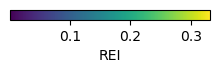

In [18]:
vmin = min(node.REI for tree in trees.values() for node in tree.tree.traverse())
vmax = max(node.REI for tree in trees.values() for node in tree.tree.traverse())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
             orientation='horizontal',
             cax=cax,
             label="REI")
plt.savefig(f"{output_dir}/cbar.pdf", bbox_inches="tight")
plt.show()

**Note:** lower bounding phenotypes according to worst single mutant

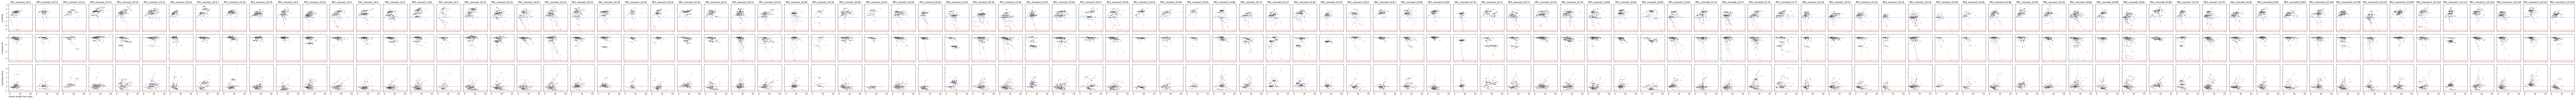

In [19]:
worst_bind = dms_df.delta_bind_CGG.min() # np.nanmin([node.delta_bind_CGG_FVS_additive for tree in trees.values() for node in tree.tree.traverse()]) - .1
worst_expr = dms_df.delta_expr.min() # np.nanmin([node.delta_expr_FVS_additive for tree in trees.values() for node in tree.tree.traverse()]) - .1
worst_psr = dms_df.delta_psr.min() # np.nanmin([node.delta_psr_FVS_additive for tree in trees.values() for node in tree.tree.traverse()]) - .1

# sim_df_clipped = sim_df.copy()
# sim_df_clipped[r"$\Delta$ affinity"].clip(lower=worst_bind, inplace=True)
# sim_df_clipped[r"$\Delta$ expression"].clip(lower=worst_expr, inplace=True)
# sim_df_clipped[r"$\Delta$ polyspecificity"].clip(lower=worst_psr, inplace=True)

fig, axes = plt.subplots(3, len(trees), figsize=(2 * len(trees), 7.5), sharex=True, sharey="row")

for i, (phenotype, phenotype_label, worst_phenotype) in enumerate(zip(("delta_bind", "delta_expr", "delta_psr"),
                                                                      (r"$\Delta$ affinity", r"$\Delta$ expression", r"$\Delta$ polyspecificity"),
                                                                      (worst_bind, worst_expr, worst_psr)
                                                                     )
                                                                  ):
    for j, (gc, tree) in enumerate(trees.items()):

        #  only 15-day and 20-day
        if gc not in metadata.index:
            raise ValueError(f"GC {gc} not found in metadata!")
        if (metadata.strain[gc] != "wt") or (metadata.time[gc] not in ("d15", "d20")):
            continue

        points = []
        lines = []
        colors = []
        
#         if j == 4: break
        
        for node in tree.tree.traverse():
            node_phenotype = getattr(node, phenotype)
            if node_phenotype < worst_phenotype:
                node_phenotype = worst_phenotype
            elif np.isnan(node_phenotype):
                node_phenotype = worst_phenotype - .2
            points.append((tree.tree.get_distance(node),
                           node_phenotype,
                           1 + 5 * node.abundance,
                           node.REI))
            if node.up is not None:
                parent_phenotype = getattr(node.up, phenotype)
                if parent_phenotype < worst_phenotype:
                    parent_phenotype = worst_phenotype
                elif np.isnan(parent_phenotype):
                    parent_phenotype = worst_phenotype - .2
                lines.append([(tree.tree.get_distance(node.up), parent_phenotype),
                              (tree.tree.get_distance(node), node_phenotype)])
            colors.append(node.REI)

        # sim_lines = []
        # for sim_idx, sim_tree in enumerate(sim_trees[gc]):
        #     for node in sim_tree.traverse():
        #         if node.up is not None:
        #             sim_lines.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
        #                               (sim_tree.get_distance(node), getattr(node, phenotype))])
        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
        # sim_lc = mc.LineCollection(sim_lines, colors="C0", linewidths=1, alpha=0.1, zorder=2)

        ax = axes[i, j]
        ax.axhline(0, c="k", ls="--", lw=0.5, zorder=1)
        ax.axhline(worst_phenotype, c="orange", ls="--", lw=1, zorder=1)
        ax.axhline(worst_phenotype - 0.2, c="r", ls="--", lw=1, zorder=1)
#         if phenotype == "delta_expr":
#             ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        ax.add_collection(lc)
        # ax.add_collection(sim_lc)
        # sns.lineplot(data=sim_df_clipped, x="divergence", y=phenotype_label, errorbar='sd', ax=ax, legend=False)
        ax.scatter(*zip(*points), cmap=cmap, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4,
                   norm=norm)   
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
        # if j == 10:
        #     break
    axes[i, 0].set_ylabel(phenotype_label)
axes[-1, 0].set_xlabel("branch length from naive")
plt.tight_layout()
plt.savefig(f"{output_dir}/phenotype-trajectories.pdf")
plt.show()

## Try aggregating trees by stratifying divergence

In [20]:
dat = []
for key, tree in trees.items():
    if (metadata.strain[gc] == "wt") and (metadata.time[key] == "d15"):
        mouse_type = "15-day"
    elif (metadata.strain[gc] == "wt") and (metadata.time[key] == "d20"):
        mouse_type = "20-day"
    else:
        raise ValueError()
    gc = gc.lstrip("GC")
    exploded_tree = tree.tree.copy(method="deepcopy")
    for node in list(exploded_tree.traverse()):
        node.img_style["size"] = 0
        if not node.is_leaf() or node.abundance > 1:
            for i in range(node.abundance):
                new_node = ete3.TreeNode()
                new_node.img_style["size"] = 0
                new_node.dist = 0
                new_node.abundance = 1
                new_node.name = f"{node.name}_{i}"
                new_node.delta_bind = node.delta_bind
                new_node.delta_expr = node.delta_expr
                new_node.delta_psr = node.delta_psr
                node.add_child(new_node)
            node.abundance = 0
    # exploded_tree.resolve_polytomy()
    exploded_tree.convert_to_ultrametric(tree_length=10 * 7 if mouse_type == "10-week" else 20, strategy="balanced")
    for node in exploded_tree.traverse():
        dat.append((key, mouse_type, node.name, node.get_distance(exploded_tree), node.delta_bind, node.delta_expr, node.delta_psr))

tree_agg_df = pd.DataFrame(dat, columns=["germinal center", "mouse type", "node", "divergence", r"$\Delta$ affinity", r"$\Delta$ expression", r"$\Delta$ polyspecificity"])

bins = np.linspace(0, 20, 14)
tree_agg_df["time (days)"] = pd.cut(tree_agg_df.divergence, bins=bins, include_lowest=True).apply(lambda x: 0 if x.left < 0 else x.right)

tree_agg_df

germinal center mouse type     node  divergence  $\Delta$ affinity  \
0        PR1_mouse1_GC1     20-day    naive         0.0           0.000000   
1        PR1_mouse1_GC1     20-day    seq62        20.0           0.082255   
2        PR1_mouse1_GC1     20-day     seq9        20.0          -1.414257   
3        PR1_mouse1_GC1     20-day    seq76        10.0          -0.663515   
4        PR1_mouse1_GC1     20-day       17        10.0          -4.941192   
...                 ...        ...      ...         ...                ...   
9606  PR2_mouse12_GC12D     15-day    seq58        20.0           0.892310   
9607  PR2_mouse12_GC12D     15-day    seq15        20.0           0.842464   
9608  PR2_mouse12_GC12D     15-day    seq26        20.0           1.232249   
9609  PR2_mouse12_GC12D     15-day    seq28        20.0           0.808975   
9610  PR2_mouse12_GC12D     15-day  seq24_0        20.0           0.808975   

      $\Delta$ expression  $\Delta$ polyspecificity time (days)  
0                 0.00000                   0.00000       0.000  
1                 0.14827                  -0.13364      20.000  
2                -1.05627                   3.34321      20.000  
3                -0.15104                  -0.15010      10.769  
4                -0.77924                   2.61806      10.769  
...                   ...                       ...         ...  
9606             -0.18826                  -0.50089      20.000  
9607             -0.38726                  -0.55808      20.000  
9608             -0.33172                  -0.48407      20.000  
9609             -0.23297                  -0.53297      20.000  
9610             -0.23297                  -0.53297      20.000  

[9611 rows x 8 columns]

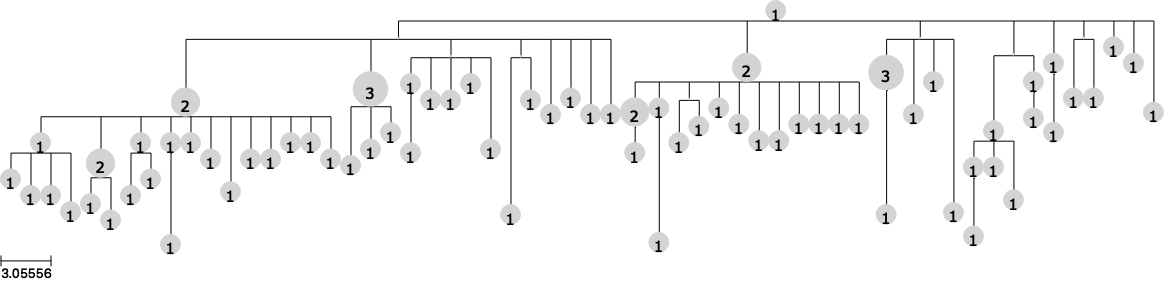

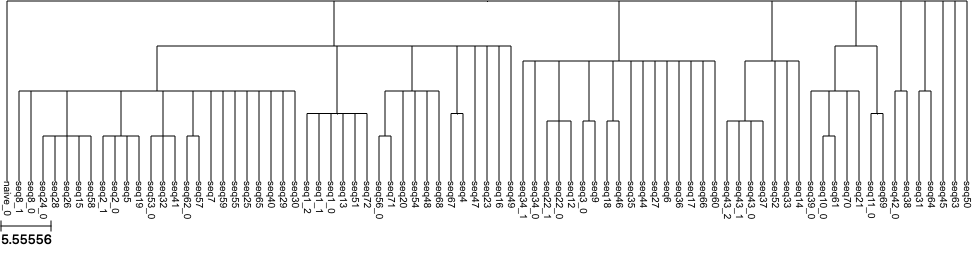

In [21]:
display(tree.render("%%inline"))

ts = ete3.TreeStyle()
ts.rotation = 90
exploded_tree.render("%%inline", tree_style=ts)

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

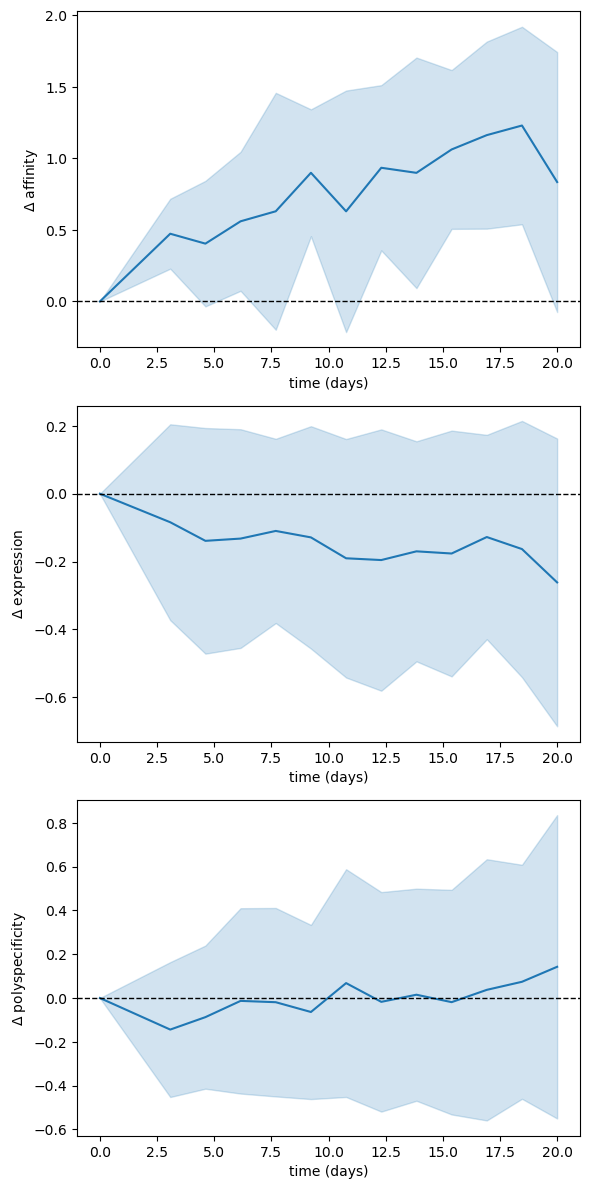

In [25]:
plt.figure(figsize=(6, 12))

plt.subplot(3, 1, 1)
sns.lineplot(
            #  data=tree_agg_df,
             data=tree_agg_df.query("`mouse type` == '20-day'"),
             x="time (days)", y=r"$\Delta$ affinity",
             hue="mouse type",
            #  units="germinal center", estimator=None,
             errorbar='sd',
             legend=False
             )
plt.axhline(0, c="k", ls="--", lw=1)

plt.subplot(3, 1, 2)
sns.lineplot(
            #  data=tree_agg_df,
             data=tree_agg_df.query("`mouse type` == '20-day'"),
             x="time (days)", y=r"$\Delta$ expression",
             hue="mouse type",
            #  units="germinal center", estimator=None,
             errorbar='sd',
             legend=False
             )
plt.axhline(0, c="k", ls="--", lw=1)

plt.subplot(3, 1, 3)
sns.lineplot(
            #  data=tree_agg_df,
             data=tree_agg_df.query("`mouse type` == '20-day'"),
             x="time (days)", y=r"$\Delta$ polyspecificity",
             hue="mouse type",
            #  units="germinal center", estimator=None,
             errorbar='sd',
             legend=False
             )
plt.axhline(0, c="k", ls="--", lw=1)

plt.tight_layout()
plt.savefig(f"{output_dir}/phenotype-trajectories.timed.pdf")
plt.show()

In [26]:
# def tree_stats(tree):
#     affinity_dat = []
#     expression_dat = []
#     cells_sampled = 0
#     rei_dat = []
#     for node in tree.traverse():
#         cells_sampled += node.abundance
#         for _ in range(node.abundance):
#             affinity_dat.append(node.delta_bind_CGG_FVS_additive)
#             expression_dat.append(node.delta_expr_FVS_additive)
#             rei_dat.append(node.REI)
#     return cells_sampled, np.nanmedian(affinity_dat), np.nanmedian(expression_dat), np.nanmax(rei_dat)

# dat = []
# for mousegc, tree in trees.items():
#     mouse, gc = mousegc.split("_")
#     mouse = int(mouse.lstrip("mouse"))
#     if mouse in (1, 2, 3, 4, 5, 6):
#         mouse_type = "20-day"
#     elif mouse in (7, 8):
#         mouse_type = "10-week"
#     elif mouse in (11, 12):
#         mouse_type = "LMP2A"
#     else:
#         raise ValueError()
#     gc = gc.lstrip("GC")
#     dat.append([mouse, mouse_type, gc, "real", *tree_stats(tree.tree)])
#     for rep_tree in sim_trees[mousegc]:
#         dat.append([mouse, mouse_type, gc, "simulated", *tree_stats(rep_tree)])

# stat_df = pd.DataFrame(dat, columns=["mouse", "mouse type", "germinal center", "data type", "cells sampled", r"median $\Delta$ affinity", r"median $\Delta$ expression", "max REI"])
# # stat_df.set_index(["mouse", "germinal center"], inplace=True)
# stat_df

In [27]:
# plt.figure(figsize=(25, 5))
# g = sns.violinplot(data=stat_df.query("`data type` == 'simulated'"),
#                 x="germinal center", y=r"median $\Delta$ affinity", hue="mouse",
#                 inner="stick", dodge=False
#                )
# sns.stripplot(data=stat_df.query("`data type` == 'real'"),
#               x="germinal center", y=r"median $\Delta$ affinity",
#               color="k", size=8)
# for item in g.get_xticklabels():
#     item.set_rotation(90)
# for tick_pos in g.get_xticks():
#     plt.axvline(tick_pos + 0.5, c="k", ls="--")
# plt.axhline(0, c="k", ls="--")
# plt.tight_layout()
# plt.savefig(f"{output_dir}/selection.pdf")
# plt.show()

# # sns.displot(data=stat_df, col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4)
# # sns.displot(data=stat_df.loc[stat_df.simulation == False], col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4, rug=True)
# # # plt.savefig(f"{plot_dir}/selection_stat.pdf")
# # plt.show()

In [28]:
# plt.figure(figsize=(6, 4))
# g = sns.scatterplot(data=stat_df.loc[stat_df["data type"] == "real"],
#                 x=r"median $\Delta$ expression", y=r"median $\Delta$ affinity", hue="mouse type",
#                 # size="cells sampled"
#                    )
# plt.axhline(0, ls="--", c="k", lw=1)
# plt.axvline(0, ls="--", c="k", lw=1)
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.savefig(f"{output_dir}/median-phenotypes.pdf")
# plt.show()

In [29]:
# rows = []
# for gc, group in stat_df.groupby("germinal center"):
#     mouse, mouse_type, true_affinity, expression, n_cells, max_rei = group.query("`data type` == 'real'")[["mouse", "mouse type", r"median $\Delta$ affinity", r"median $\Delta$ expression", "cells sampled", "max REI"]].iloc[0]
#     null_affinities = group.query("`data type` == 'simulated'")[r"median $\Delta$ affinity"]
#     # z score for selection
#     selection = (true_affinity - null_affinities.mean()) / null_affinities.std()
#     rows.append([gc, mouse, mouse_type, n_cells, max_rei, true_affinity, expression, selection])

# selection_df = pd.DataFrame(data=rows, columns=("germinal center", "mouse", "mouse type", "cells sampled", "max REI", r"median $\Delta$ affinity", r"median $\Delta$ expression", "affinity selection strength"))
# selection_df

In [30]:
# order = ("20-day", "10-week", "LMP2A")

# plt.figure(figsize=(5, 9))

# plt.subplot(311)
# g = sns.boxplot(data=selection_df, x="mouse type", y=r"median $\Delta$ affinity", color="lightgrey", order=order)
# g = sns.swarmplot(data=selection_df, x="mouse type", y=r"median $\Delta$ affinity", color="k", order=order)
# plt.axhline(0, ls="--", c="k", lw=1)

# plt.subplot(312)
# g = sns.boxplot(data=selection_df, x="mouse type", y=r"median $\Delta$ expression", color="lightgrey", order=order)
# g = sns.swarmplot(data=selection_df, x="mouse type", y=r"median $\Delta$ expression", color="k", order=order)
# plt.axhline(0, ls="--", c="k", lw=1)

# plt.subplot(313)
# g = sns.boxplot(data=selection_df, x="mouse type", y="affinity selection strength", color="lightgrey", order=order)
# g = sns.swarmplot(data=selection_df, x="mouse type", y="affinity selection strength", color="k", order=order)
# plt.axhline(0, ls="--", c="k", lw=1)

# plt.tight_layout()
# plt.savefig(f"{output_dir}/selection-boxplots.pdf")
# plt.show()

In [31]:
# from scipy.stats import mannwhitneyu
# mannwhitneyu(selection_df.query("`mouse type` == '20-day'")[r"median $\Delta$ affinity"], selection_df.query("`mouse type` == 'LMP2A'")[r"median $\Delta$ affinity"])

In [32]:
# selection_df.groupby("mouse type").median().drop(columns="mouse")

In [34]:
dat = []
for key, tree in trees.items():
    mouse = "_".join(key.split("_")[:2])
    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in tree.tree.children]
    dom_score = max(clade_sizes) / sum(clade_sizes)
    max_REI = np.nanmax([node.REI for node in tree.tree.traverse()])
    
    for node in tree.tree.traverse():
        stop_ct = node.abundance if np.isnan(node.delta_bind) else 0
        if node.abundance:
            dat.append([key, mouse, node.name, node.abundance, stop_ct, tree.tree.get_distance(node), node.delta_bind, node.delta_expr, node.delta_psr])

cell_df = pd.DataFrame(dat, columns=("germinal center", "mouse", "id", "cells sampled", "unproductive cells", "divergence from naive BCR", r"$\Delta$ affinity", r"$\Delta$ expression", r"$\Delta$ polyspecificity"))

cell_df[r"$\Delta$ affinity"] = cell_df[r"$\Delta$ affinity"].clip(lower=worst_bind)
cell_df[r"$\Delta$ expression"] = cell_df[r"$\Delta$ expression"].clip(lower=worst_expr)
cell_df[r"$\Delta$ polyspecificity"] = cell_df[r"$\Delta$ polyspecificity"].clip(lower=worst_expr)

cell_df

germinal center        mouse     id  cells sampled  \
0        PR1_mouse1_GC1   PR1_mouse1  seq62              1   
1        PR1_mouse1_GC1   PR1_mouse1   seq9              1   
2        PR1_mouse1_GC1   PR1_mouse1  seq76              1   
3        PR1_mouse1_GC1   PR1_mouse1  seq17              1   
4        PR1_mouse1_GC1   PR1_mouse1  seq51              1   
...                 ...          ...    ...            ...   
6428  PR2_mouse12_GC12D  PR2_mouse12   seq5              1   
6429  PR2_mouse12_GC12D  PR2_mouse12  seq58              1   
6430  PR2_mouse12_GC12D  PR2_mouse12  seq15              1   
6431  PR2_mouse12_GC12D  PR2_mouse12  seq26              1   
6432  PR2_mouse12_GC12D  PR2_mouse12  seq28              1   

      unproductive cells  divergence from naive BCR  $\Delta$ affinity  \
0                      0                        4.0           0.082255   
1                      0                       11.0          -1.414257   
2                      0                        1.0          -0.663515   
3                      0                        3.0          -1.263051   
4                      0                        9.0          -3.030001   
...                  ...                        ...                ...   
6428                   0                        7.0           0.906618   
6429                   0                        8.0           0.892310   
6430                   0                        7.0           0.842464   
6431                   0                        7.0           1.232249   
6432                   0                        6.0           0.808975   

      $\Delta$ expression  $\Delta$ polyspecificity  
0                 0.14827                  -0.13364  
1                -1.05627                   3.34321  
2                -0.15104                  -0.15010  
3                -0.34882                  -0.16985  
4                -0.81985                   2.62302  
...                   ...                       ...  
6428             -0.09020                  -0.85437  
6429             -0.18826                  -0.50089  
6430             -0.38726                  -0.55808  
6431             -0.33172                  -0.48407  
6432             -0.23297                  -0.53297  

[6433 rows x 9 columns]

Note: violins not weighted by abundance

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

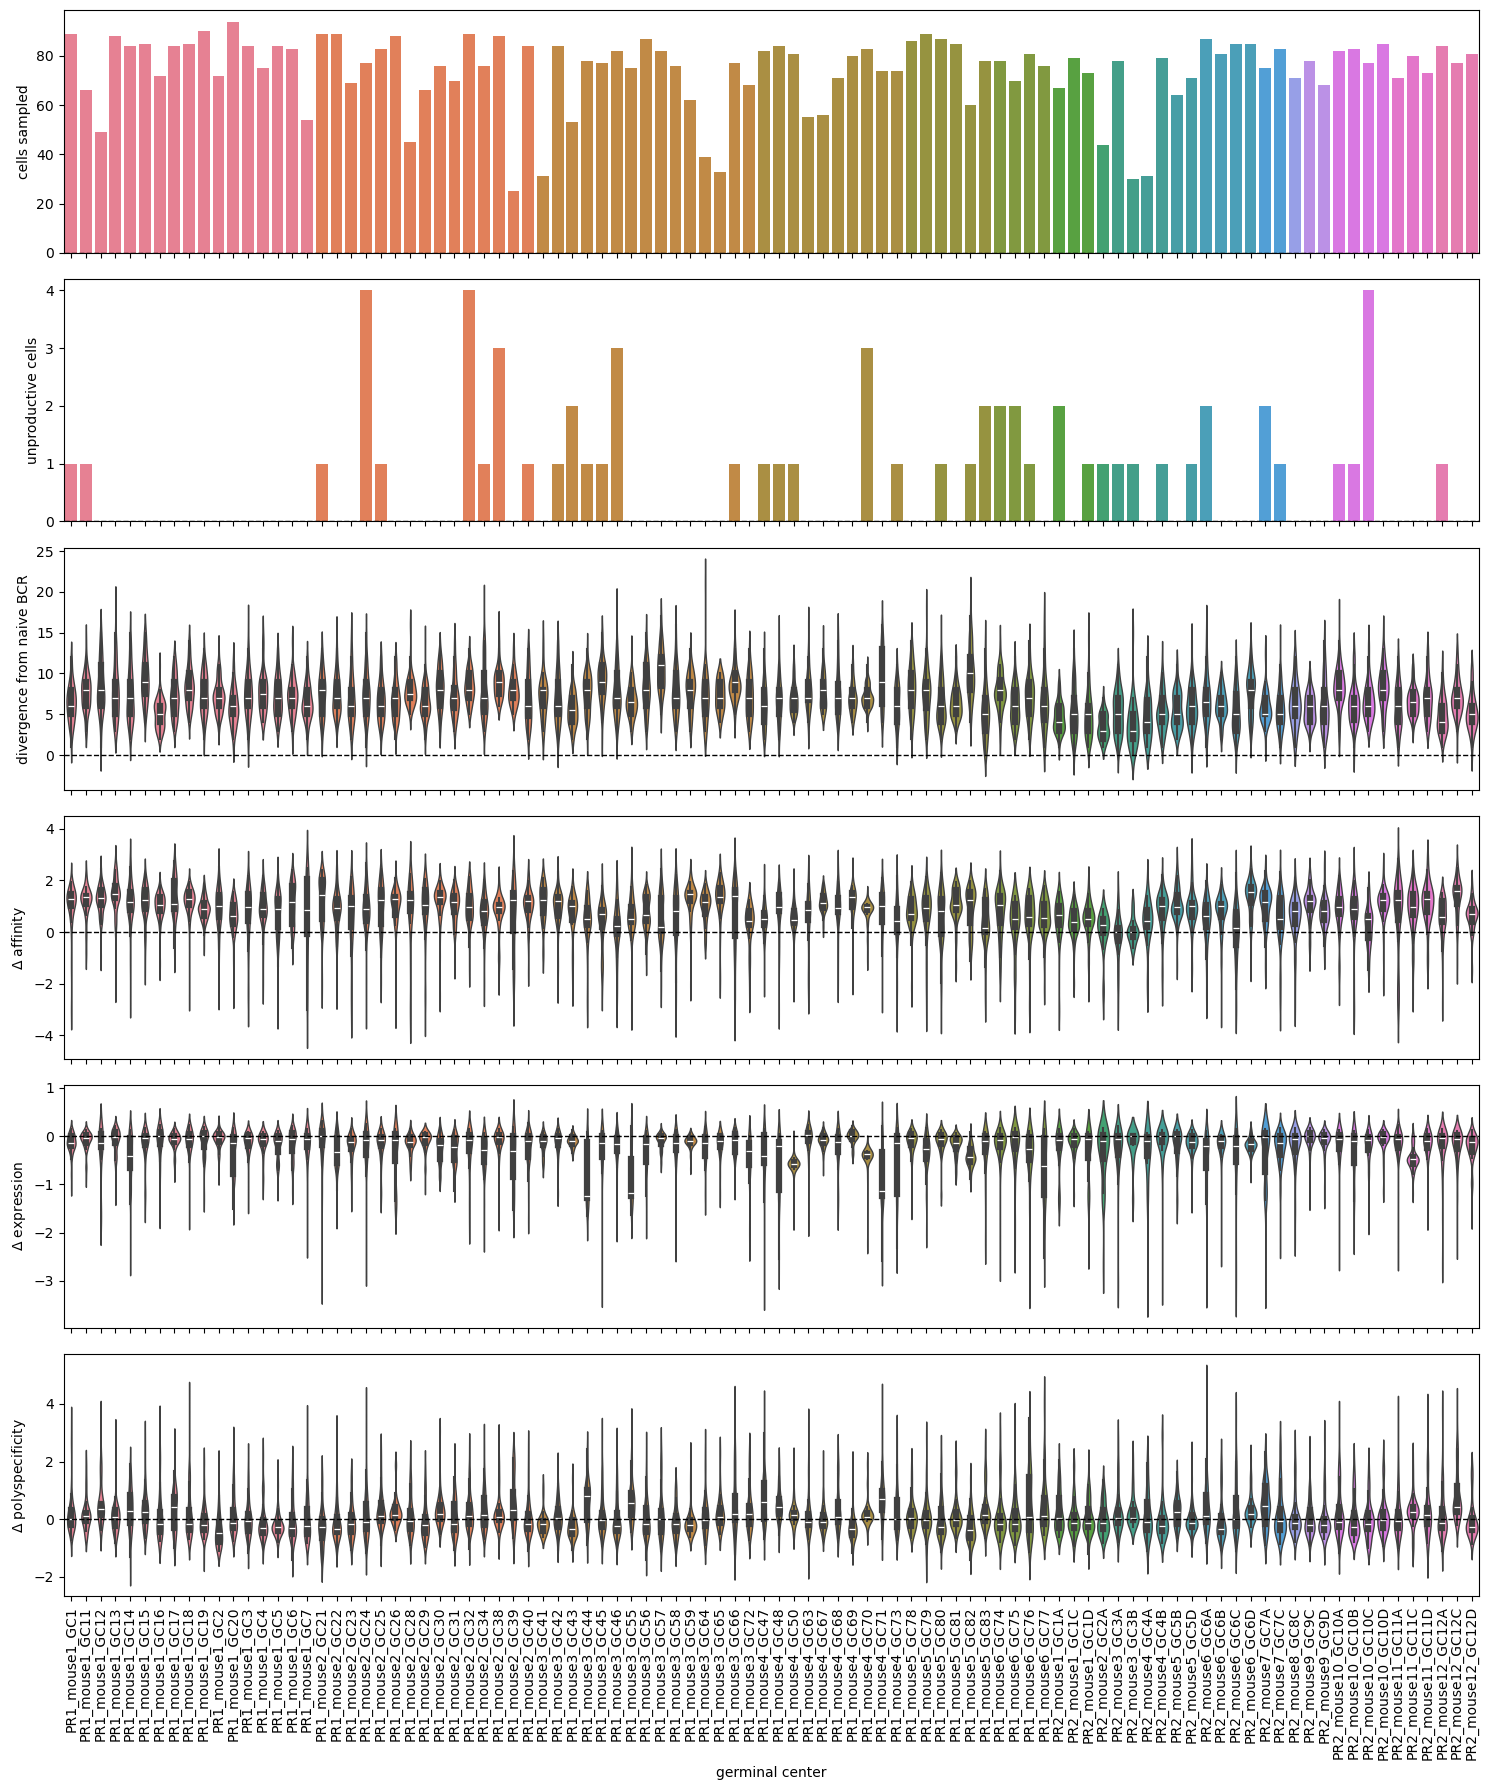

In [35]:
# order = cell_df.groupby("germinal center").agg({"mouse": "first", "cells sampled": sum}).sort_values(["mouse", "cells sampled"]).index

fig, axes = plt.subplots(6, 1, sharex="col", figsize=(15, 18))

sns.barplot(data=cell_df, x="germinal center", hue="mouse", y="cells sampled",
            errorbar=None, estimator=sum, dodge=False, ax=axes[0], legend=False)
# sns.move_legend(axes[0], "upper left")
axes[0].set(xlabel=None)
axes[0].axhline(0, ls="--", c="k", lw=1)

g = sns.barplot(data=cell_df, x="germinal center", hue="mouse", y="unproductive cells",
                legend=False,
                errorbar=None, estimator=sum, dodge=False, ax=axes[1])
axes[1].set(xlabel=None)
axes[1].axhline(0, ls="--", c="k", lw=1)

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y="divergence from naive BCR", #weights="abundance",
                    dodge=False, legend=False, linewidth=1, ax=axes[2])
axes[2].set(xlabel=None)
axes[2].axhline(0, ls="--", c="k", lw=1)

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y=r"$\Delta$ affinity", #weights="abundance",
                    dodge=False, legend=False, linewidth=1, ax=axes[3])
axes[3].set(xlabel=None)
axes[3].axhline(0, ls="--", c="k", lw=1)

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y=r"$\Delta$ expression", #weights="abundance",
                    dodge=False, legend=False, linewidth=1, ax=axes[4])
axes[4].axhline(0, ls="--", c="k", lw=1)

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y=r"$\Delta$ polyspecificity", #weights="abundance",
                    dodge=False, legend=False, linewidth=1, ax=axes[5])
axes[5].axhline(0, ls="--", c="k", lw=1)

plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(f"{output_dir}/cell-summary.pdf")
plt.show()